In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from moviepy.editor import VideoFileClip
%matplotlib inline
#%matplotlib qt

#### Camera calibration

In [2]:
# Computes the camera calibration for all the images in the input folder path and returns the matrix and distortion coefficients
def get_calibration_coeffs(image_url):
    images = glob.glob(image_url)

    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    corner = (9, 6)
    
    for image in images:
        img = cv2.imread(image)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, corner, None)

        if ret:            
            objpoints.append(objp)
            imgpoints.append(corners)
            
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dst, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    return mtx, dst


In [3]:
mtx, dst = get_calibration_coeffs('./camera_cal/calibration*.jpg')
calib_coeffs = {}
calib_coeffs['mtx'] = mtx
calib_coeffs['dst'] = dst
pickle.dump(calib_coeffs, open('calibration.p', 'wb'))

#### Set test images

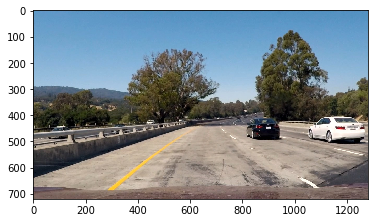

In [4]:
test_img = cv2.imread('./test_images/test1.jpg')
#convert RGB to BGR
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
plt.imshow(test_img)

### 2. Distortion correction

In [5]:
def undistort_img(img, mtx, dst):
    dst = cv2.undistort(img, mtx, dst, None, mtx)
    return dst

#### Distortion corrected calibrated image (chessboard)

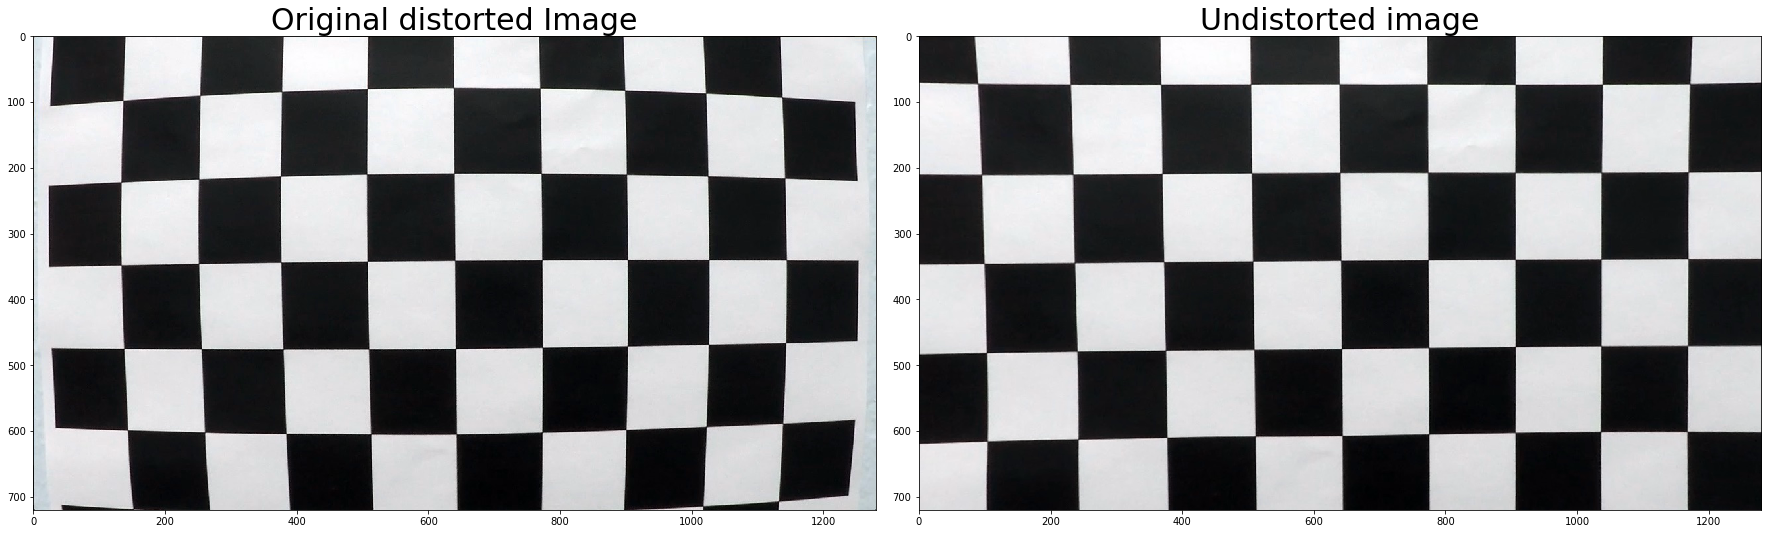

In [6]:
img = cv2.imread('./camera_cal/calibration1.jpg')
undist = undistort_img(img, mtx, dst)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
plt.imsave('./output_images/undistorted_chess_image.png', undist)
ax1.imshow(img)
ax1.set_title('Original distorted Image', fontsize=30)

ax2.imshow(undist)
ax2.set_title('Undistorted image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

undist_test_img = undistort_img(test_img, mtx, dst)

#### Distortion corrected test image

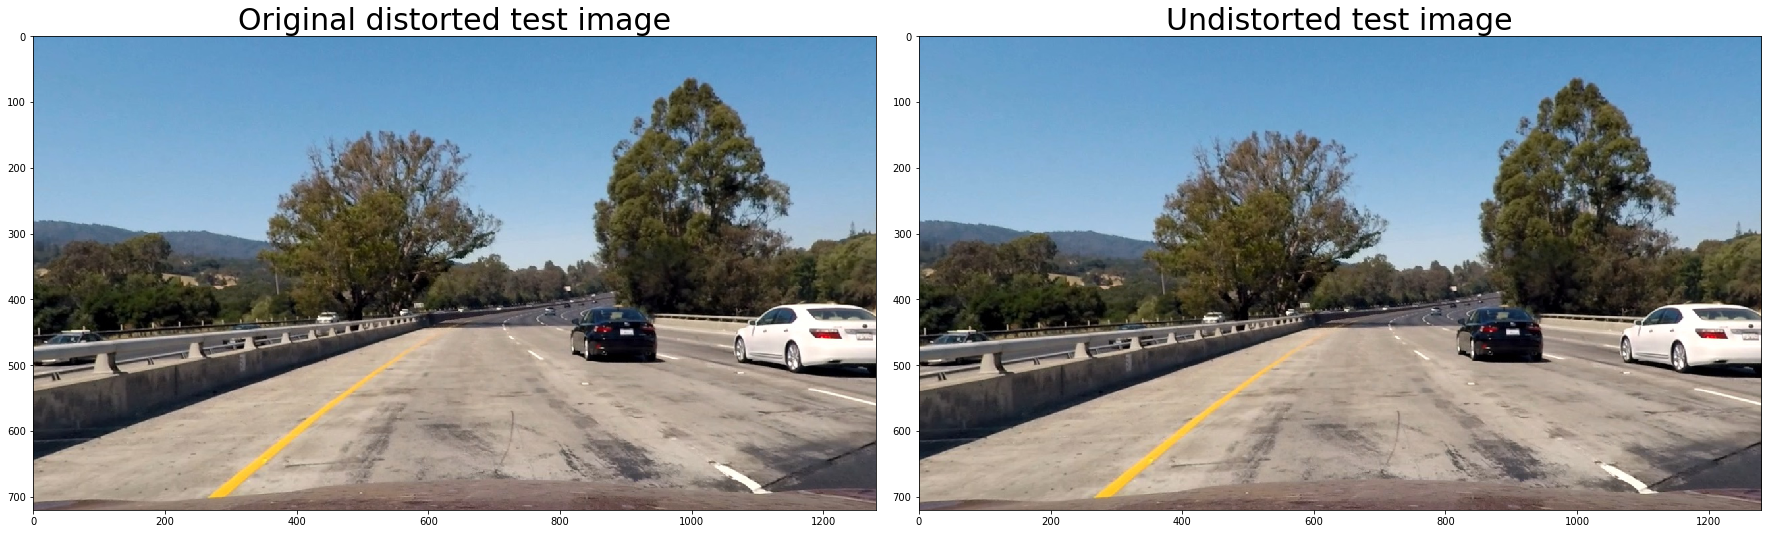

In [7]:
undist = undistort_img(test_img, mtx, dst)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
plt.imsave('./output_images/undistorted_test_image.png', undist)
ax1.imshow(undist)
ax1.set_title('Original distorted test image', fontsize=30)

ax2.imshow(undist)
ax2.set_title('Undistorted test image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

undist_test_img = undistort_img(test_img, mtx, dst)

### 3. Color transform & Gradient

In [8]:
# Absolute sobel for x & y axes
def abs_sobel(img, sobel_kernel=3, abs_thresh=(0,255), orient='x'):
    
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    orient_x, orient_y = 1, 0
    if orient == 'y':
        orient_x, orient_y = 0, 1
    sobel = cv2.Sobel(img_gray, cv2.CV_64F, orient_x, orient_y,sobel_kernel)
    abs_sobel = np.abs(sobel)
    scaled_sobel = np.uint8(255*abs_sobel / np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= abs_thresh[0]) & (scaled_sobel <= abs_thresh[1])] = 1
    return grad_binary

In [9]:
# Magnitude gradient
def mag_sobel(image, sobel_kernel=3, mag_thresh=(0,255)):
    
    img_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(img_gray, cv2.CV_64F, 1,0, sobel_kernel)
    sobely = cv2.Sobel(img_gray, cv2.CV_64F, 0,1, sobel_kernel)
    abs_sobelx = np.abs(sobelx)
    abs_sobely = np.abs(sobely)
    sobel_mag = np.sqrt(np.square(abs_sobelx) + np.square(abs_sobely))
    scaled_sobel = np.uint8(255*sobel_mag / np.max(sobel_mag))
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    return sbinary

In [10]:
# Direction of the gradient
def dir_sobel(image, sobel_kernel=3, dir_thresh=(0,255)):
    
    img_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(img_gray, cv2.CV_64F, 1,0, sobel_kernel)
    sobely = cv2.Sobel(img_gray, cv2.CV_64F, 0,1, sobel_kernel)
    abs_sobelx = np.abs(sobelx)
    abs_sobely = np.abs(sobely)
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(grad_dir)
    
    dir_binary[(grad_dir >= dir_thresh[0]) & (grad_dir <= dir_thresh[1])] = 1
    
    return dir_binary

In [11]:
# Combined sobel, magnitude and direction gradient
def combined_grad(image, kernel=3, abs_thresh=(30,100), mag_thresh = (10,100), dir_thresh = (0,0.5)):
    gradx = abs_sobel(image, kernel, abs_thresh, orient='x')
    grady = abs_sobel(image, kernel, abs_thresh, orient='y')
    mag_binary = mag_sobel(image, kernel, mag_thresh)
    dir_binary = dir_sobel(image, kernel, dir_thresh)


    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return combined

#### Test of absolute, magnitude & directional gradient

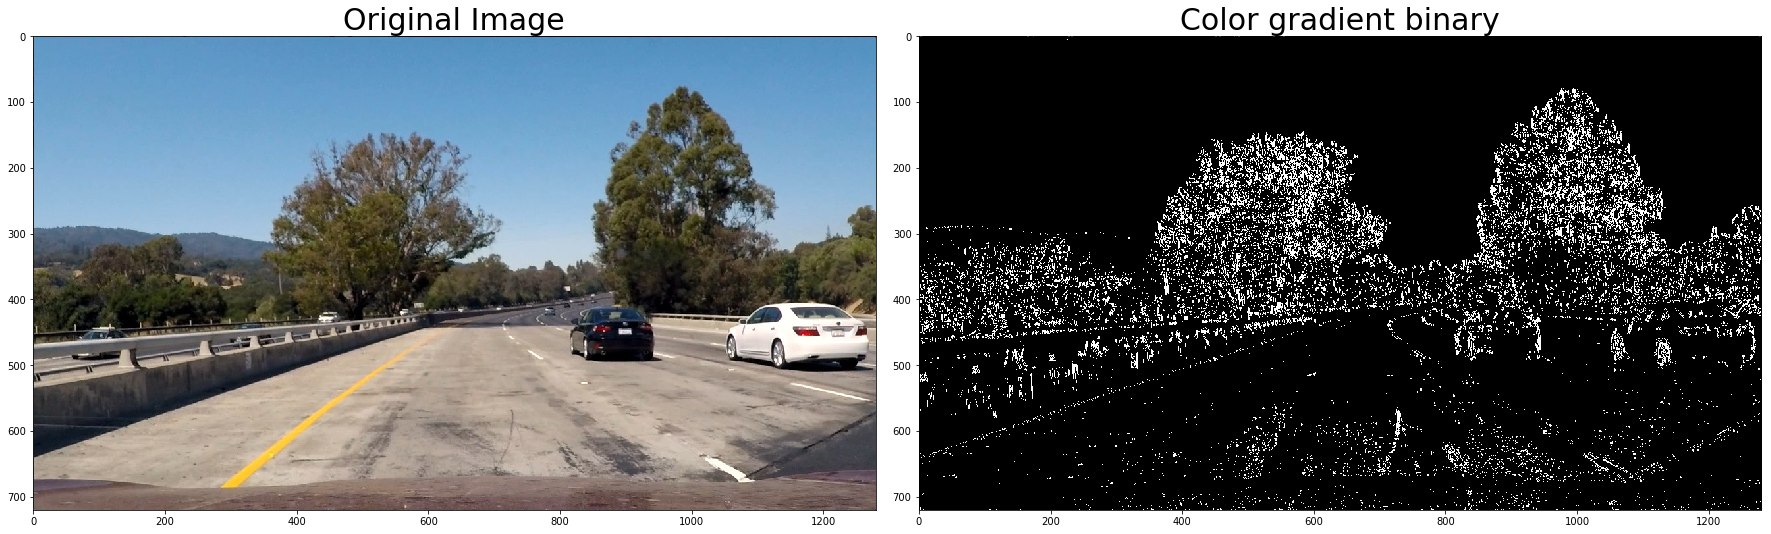

In [12]:
img = cv2.imread('./test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
color_thresh = combined_grad(img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
plt.imsave('./output_images/grad_img.png', color_thresh, cmap='gray')
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)

ax2.imshow(color_thresh, cmap='gray')
ax2.set_title('Color gradient binary', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### HLS Threshold for S channel

In [13]:
def hls_sthresh(img, thresh=(80, 255)):
    
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    hls_s = hls[:,:,2]
    hls_s = hls_s*(255/np.max(hls_s))
    binary_output = np.zeros_like(hls_s)
    binary_output[(hls_s > thresh[0]) & (hls_s <= thresh[1])] = 1
    
    return binary_output

#### RGB Threshold for R Channel

In [14]:
def rgb_rthresh(img, thresh=(230, 255)):
    
    rgb_r = img[:,:,0]
    rgb_r = rgb_r*(255/np.max(rgb_r))
    binary_output = np.zeros_like(rgb_r)
    binary_output[(rgb_r > thresh[0]) & (rgb_r <= thresh[1])] = 1

    return binary_output

#### Color transform and gradient test

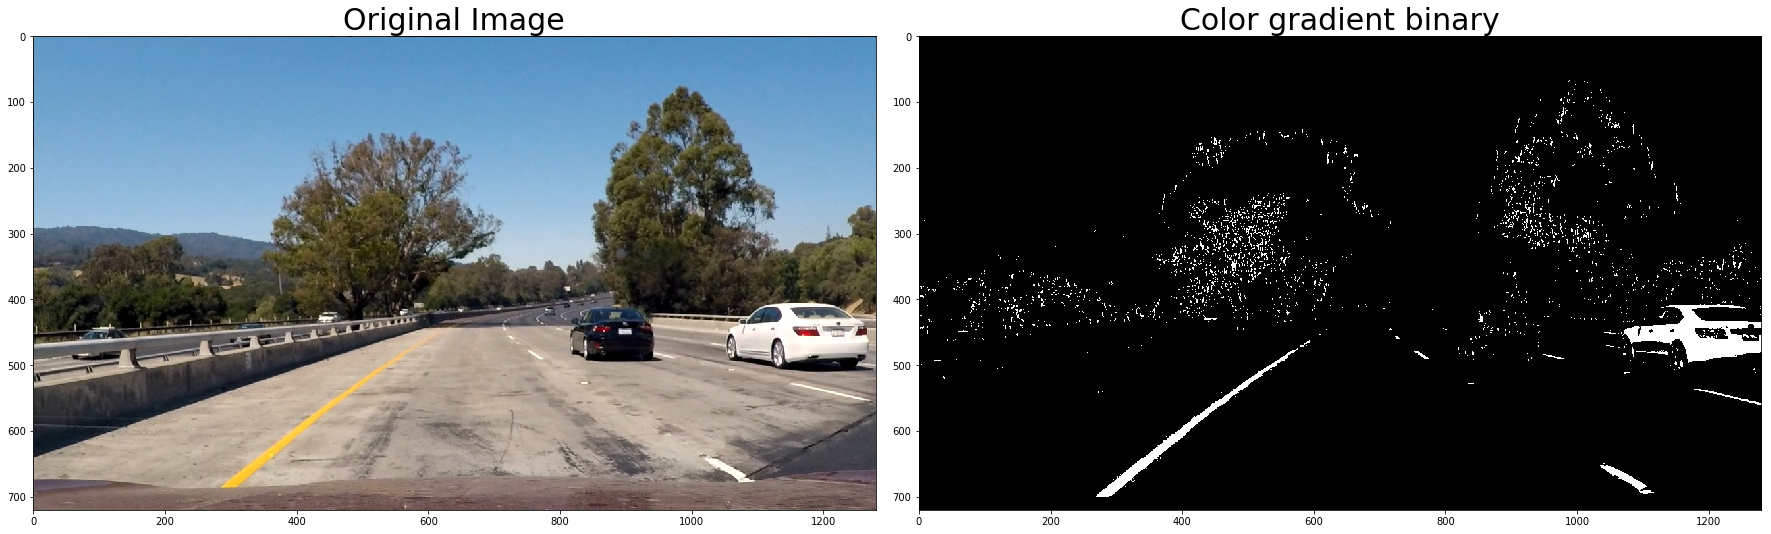

In [15]:
undist_img = undistort_img(test_img, mtx, dst)
grad_img = combined_grad(undist_img)
hls_s_img = hls_sthresh(undist_img)
rgb_r_img = rgb_rthresh(undist_img)
binary_warped_test = np.zeros_like(hls_s_img)
binary_warped_test[((hls_s_img == 1) & (grad_img == 1)) | (rgb_r_img == 1)] = 1

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
plt.imsave('./output_images/color_grad_img.png', binary_warped_test, cmap='gray')
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)

ax2.imshow(binary_warped_test, cmap='gray')
ax2.set_title('Color gradient binary', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### Source and destination points for warp

In [16]:
src = np.array([[253, 697],[585, 456],
                        [700, 456],[1061, 690]], dtype=np.float32)
dest = np.array([[303, 697], [303, 0],
                        [1011, 0],[1011, 690]], dtype=np.float32)

### 4. Perspective transform

In [17]:
class Perspective_Transform():
    def __init__(self, src, dst):
        self.src = src
        self.dst = dst
        self.M = cv2.getPerspectiveTransform(self.src, self.dst)
        self.inverse_M = cv2.getPerspectiveTransform(self.dst, self.src)
        
    def transform(self, undist):
        return cv2.warpPerspective(undist, self.M, (undist.shape[1], undist.shape[0]), flags=cv2.INTER_LINEAR)
    
    def inverse_transform(self, undist):
        return self.inverse_M


#### Perspective transform test

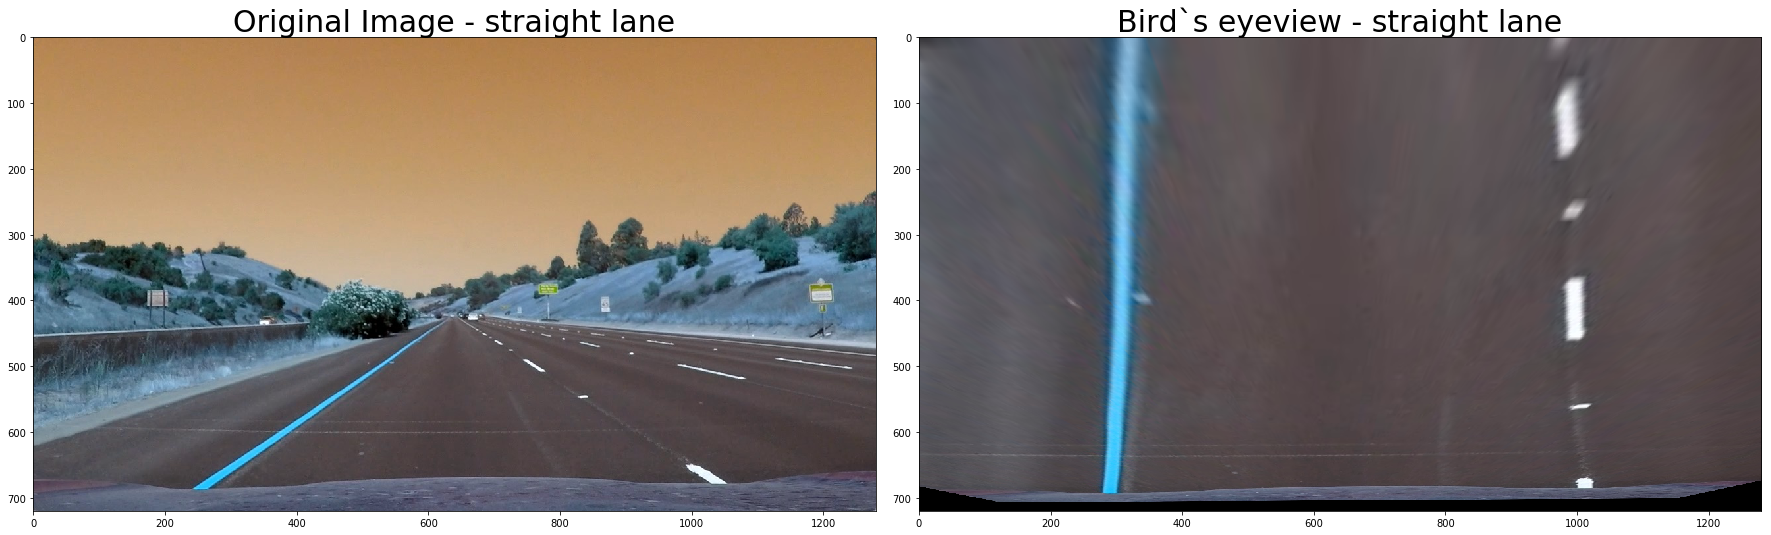

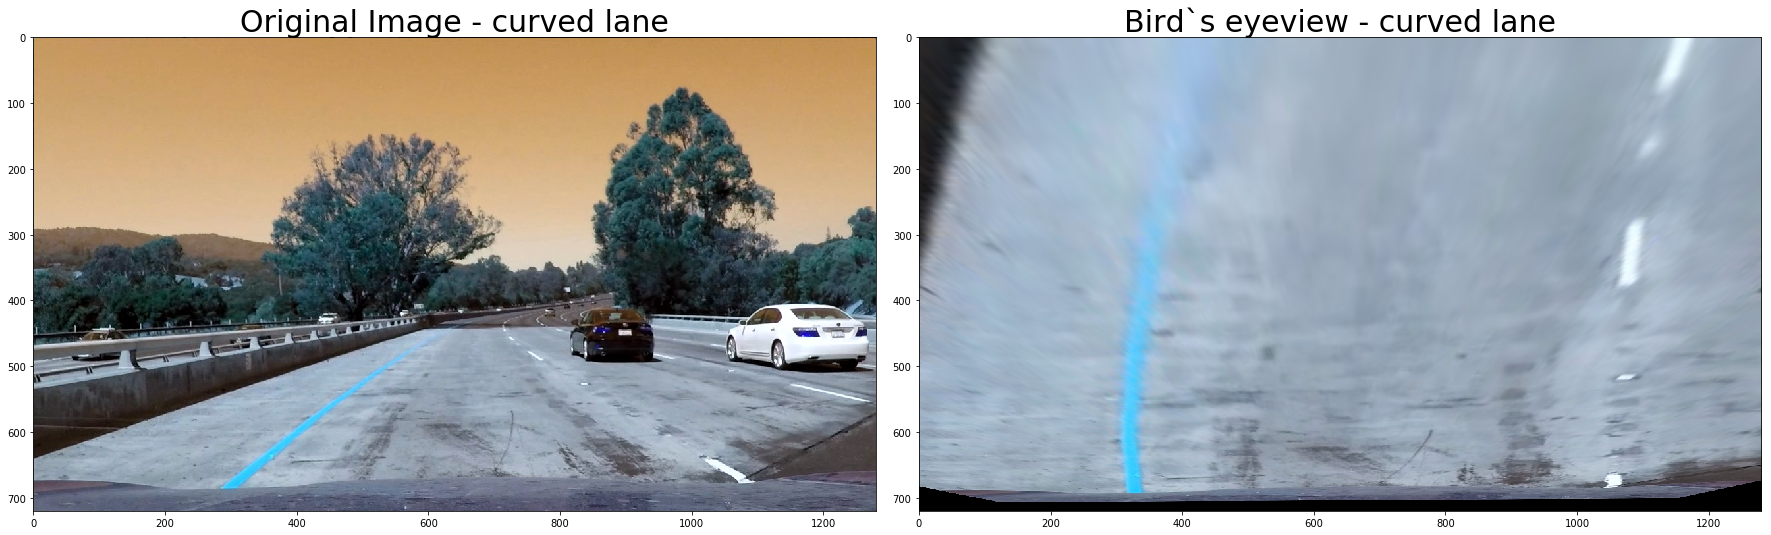

In [18]:
# Straight road warp

img_straight = cv2.imread('./test_images/straight_lines1.jpg')

img_size = (img_straight.shape[1], img_straight.shape[0])


persp_xform = Perspective_Transform(src, dest)

top_down_view_straight = persp_xform.transform(img_straight)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
plt.imsave('./output_images/persp_xform_straight.png', top_down_view_straight)
ax1.imshow(img_straight)
ax1.set_title('Original Image - straight lane', fontsize=30)

ax2.imshow(top_down_view_straight)
ax2.set_title('Bird`s eyeview - straight lane', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


# Curved road warp

img_curved = cv2.imread('./test_images/test1.jpg')

img_size = (img_curved.shape[1], img_curved.shape[0])

top_down_view_curved = persp_xform.transform(img_curved)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
plt.imsave('./output_images/persp_xform_curved.png', top_down_view_curved)
ax1.imshow(img_curved)
ax1.set_title('Original Image - curved lane', fontsize=30)

ax2.imshow(top_down_view_curved)
ax2.set_title('Bird`s eyeview - curved lane', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### Image pipeline

In [19]:
def binary_img_pipeline(img):
    undist_img = undistort_img(img, mtx, dst)
    persp_xform = Perspective_Transform(src, dest)
    warped_img = persp_xform.transform(undist_img)
    M_inv = persp_xform.inverse_transform(undist_img)
    grad_img = combined_grad(warped_img)
    hls_s_img = hls_sthresh(warped_img)
    rgb_r_img = rgb_rthresh(warped_img)
    binary_warped = np.zeros_like(hls_s_img)
    binary_warped[((hls_s_img == 1) & (grad_img == 1)) | (rgb_r_img == 1)] = 1
    return binary_warped, M_inv
    

In [20]:
def binary_img_warped(img):
    binary_warped, _ = binary_img_pipeline(img)
    i = np.random.randint(0,101)
    imgname = './output_images/binary_warped' + str(i) + '.png'
    plt.imsave(imgname, binary_warped, cmap='gray')
   
    return binary_warped

#### Image pipeline test

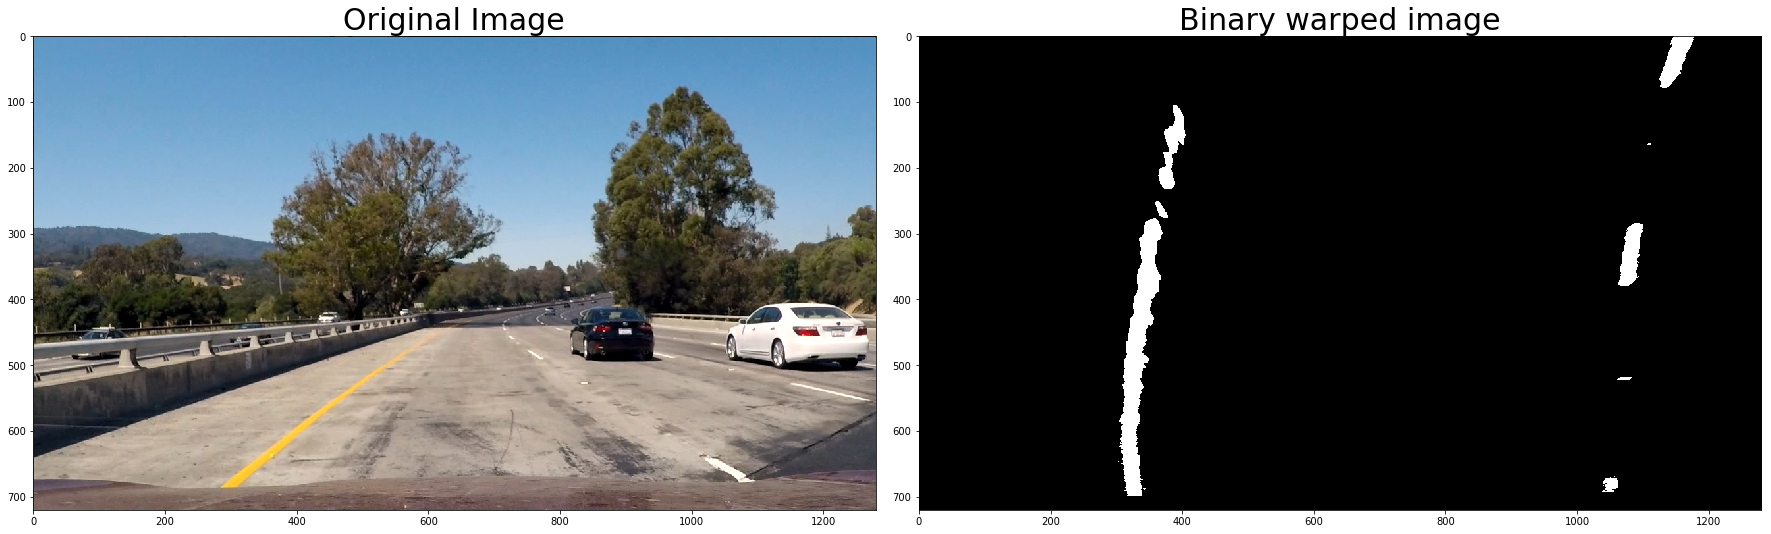

In [21]:
img = cv2.imread('./test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
binary_warped, _ = binary_img_pipeline(img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
plt.imsave('./output_images/pipeline_img.png', binary_warped, cmap='gray')
ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Binary warped image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### 5. Identify lane lines & fit to a polynomial

In [22]:
def sliding_window_lane_fit_polynomial(binary_warped):
    
    # Histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Peak of the left & right halves to be used as starting point for respective lanes

    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint


    nwindows = 9
    
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    window_data = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        window_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    #if len(leftx) != 0:
    left_fit = np.polyfit(lefty, leftx, 2)
    #if len(rightx) != 0:
    right_fit = np.polyfit(righty, rightx, 2)
  

    return left_fit, right_fit, left_lane_inds, right_lane_inds, window_data, histogram

#### Lane line fit test for all test images

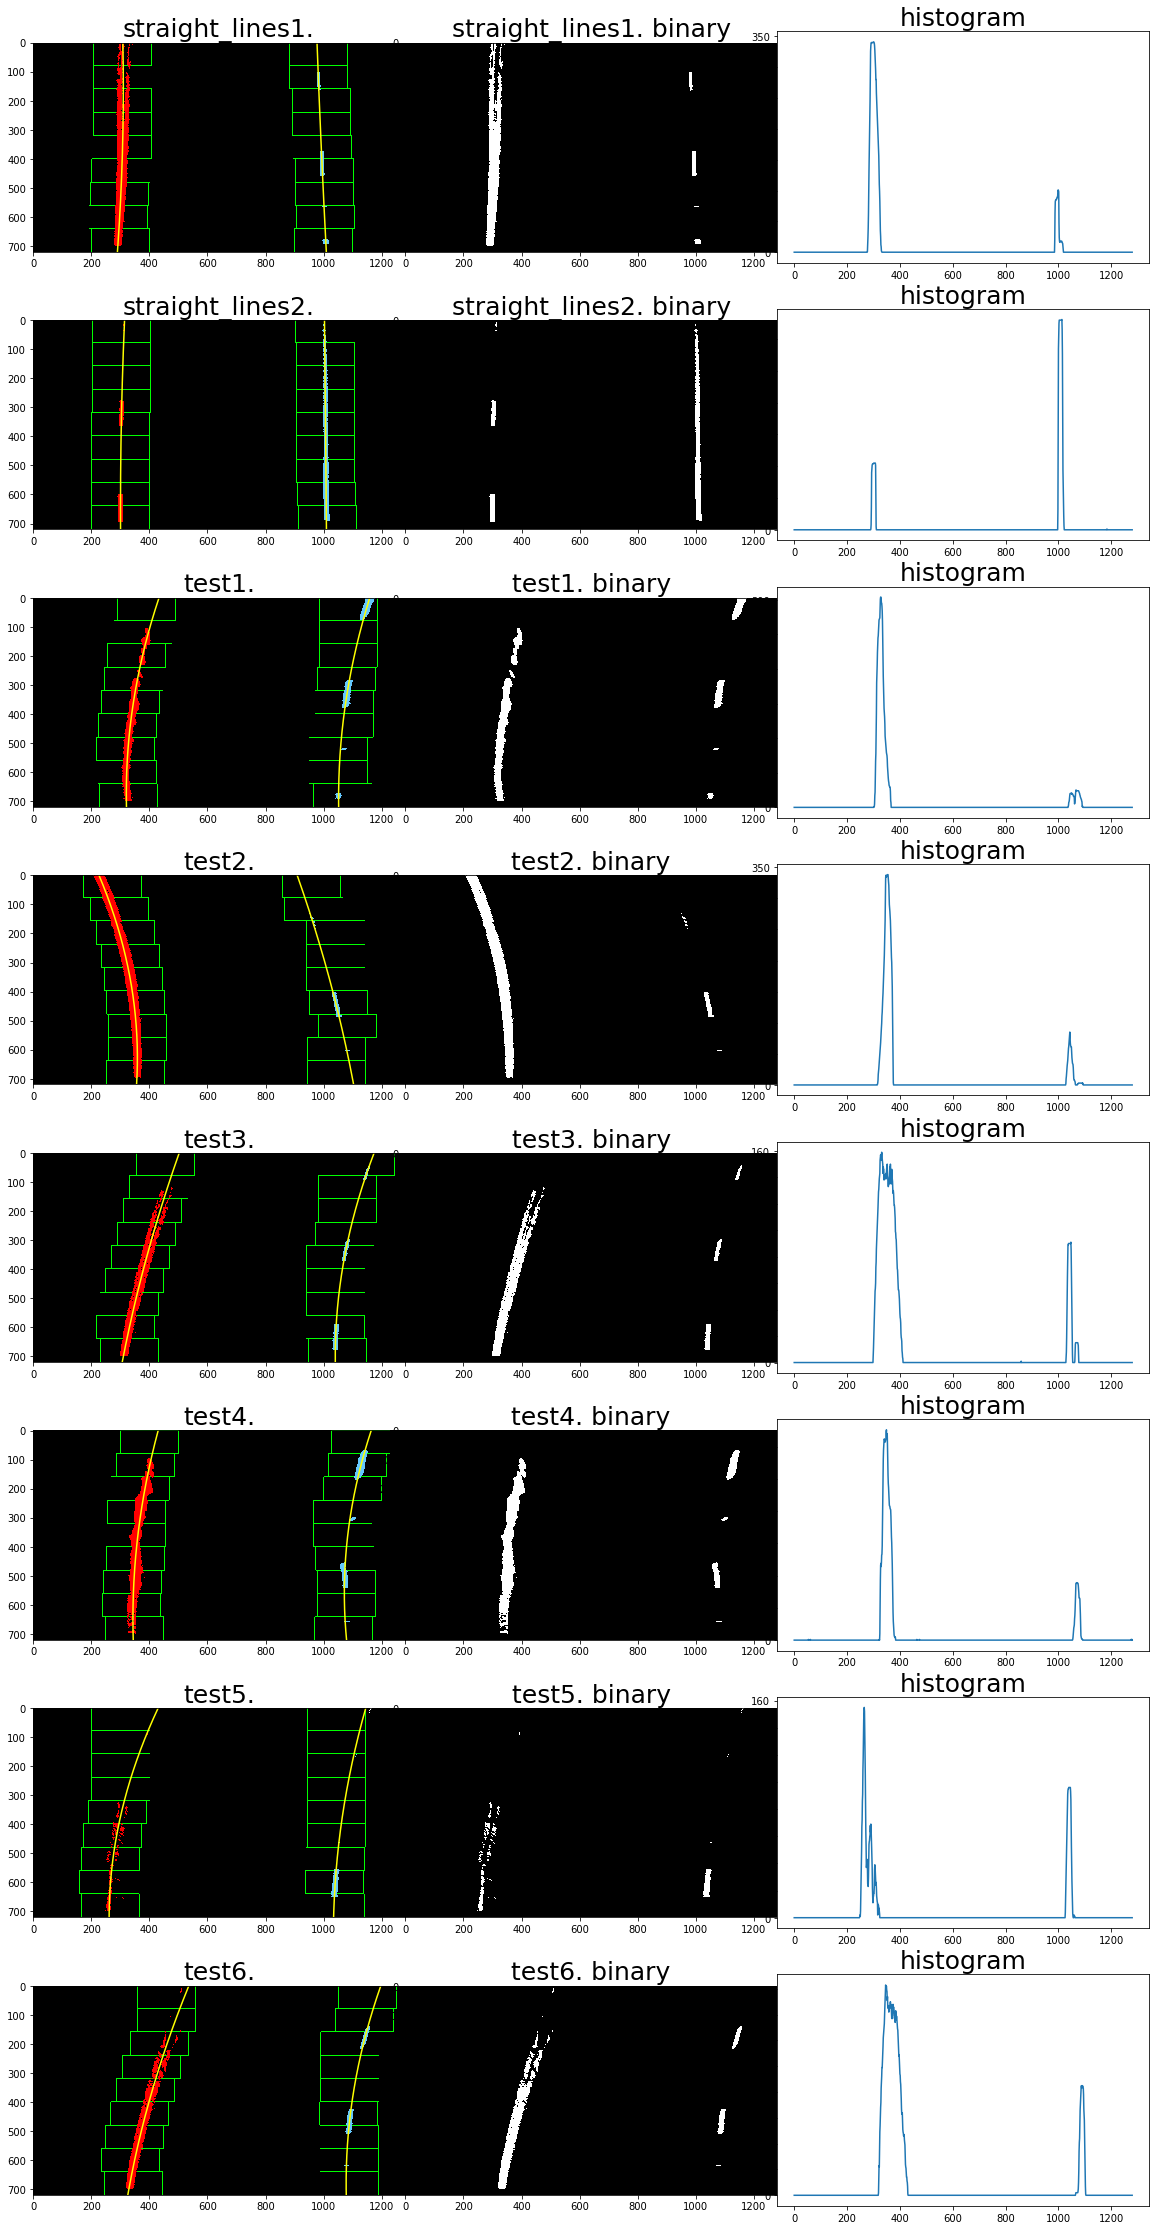

In [23]:
def sliding_window_lane_fit_polynomial_test(image):
    test_img = image
    
    if isinstance(image, str):
        test_img = cv2.imread(image)
        test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    
    testimg_binary, _ = binary_img_pipeline(test_img)
    
    left_fit, right_fit, left_lane_inds, right_lane_inds, windows_data, histogram = sliding_window_lane_fit_polynomial(testimg_binary)

    # Generate x and y values for plotting
    ploty = np.linspace(0, testimg_binary.shape[0]-1, testimg_binary.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an output image to draw on and  visualize the result
    out_img = np.uint8(np.dstack((testimg_binary, testimg_binary, testimg_binary))*255)

    for window in windows_data:
    # Draw the windows on the visualization image
        cv2.rectangle(out_img,(window[2],window[0]),(window[3],window[1]),(0,255,0), 2) 
        cv2.rectangle(out_img,(window[4],window[0]),(window[5],window[1]),(0,255,0), 2) 

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = testimg_binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [100, 200, 255]
    return out_img, left_fitx, right_fitx, ploty, testimg_binary, histogram

def sliding_window_lane_fit_polynomial_img_output(img):
    out_img, _, _, _, _ = sliding_window_lane_fit_polynomial_test(img)
    return out_img

images = glob.glob('./test_images/*.jpg')
fig, axs = plt.subplots(len(images),3, figsize=(20, 40))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

i = 0

for image in images:
    out_img, left_fitx, right_fitx, ploty, testimg_binary, histogram = sliding_window_lane_fit_polynomial_test(image)
    axs[i].imshow(out_img)
    img_name = image[image.index('\\')+1:image.index('jpg')]
    axs[i].set_title(img_name, fontsize=25)
    axs[i].plot(left_fitx, ploty, color='yellow')
    axs[i].plot(right_fitx, ploty, color='yellow')
    
    out_img_binary = img_name + '_binary.png'
    out_img_lanefit = img_name + '_lane_fit.png'
    plt.imsave('./output_images/' + out_img_binary, testimg_binary, cmap='gray')
    plt.imsave('./output_images/' + out_img_lanefit, out_img)
    
    i += 1
    axs[i].set_title(img_name + ' binary', fontsize=25)
    axs[i].imshow(testimg_binary, cmap='gray')

    i += 1
    
    axs[i].set_title('histogram', fontsize=25)
    axs[i].plot(histogram)
    i += 1


#### Fit from a previous frame

In [24]:
def lane_fit_from_prev_frame(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds

#### Previous frame fit test

(720, 0)

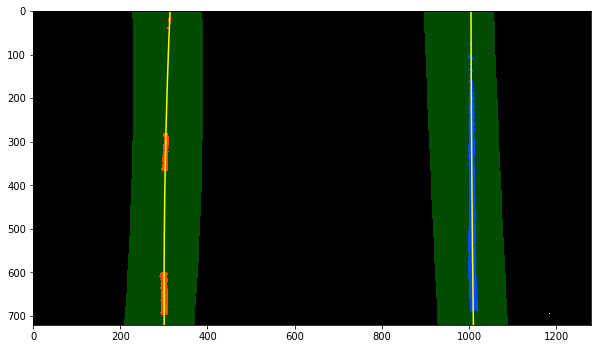

In [25]:
test_img1 = cv2.imread('./test_images/straight_lines1.jpg')
test_img1 = cv2.cvtColor(test_img1, cv2.COLOR_BGR2RGB)
test_img1_binary, _ = binary_img_pipeline(test_img1)   

test_img2 = cv2.imread('./test_images/straight_lines2.jpg')
tes_img2 = cv2.cvtColor(test_img2, cv2.COLOR_BGR2RGB)
test_img2_binary, _ = binary_img_pipeline(test_img2)   
margin = 80

left_fit1, right_fit1, left_lane_inds1, right_lane_inds1, windows_data1, histogram1 = sliding_window_lane_fit_polynomial(test_img1_binary)

left_fit2, right_fit2, left_lane_inds2, right_lane_inds2 = lane_fit_from_prev_frame(test_img2_binary, left_fit1, right_fit1)


ploty = np.linspace(0, test_img2_binary.shape[0]-1, test_img2_binary.shape[0] )
left_fitx = left_fit1[0]*ploty**2 + left_fit1[1]*ploty + left_fit1[2]
right_fitx = right_fit1[0]*ploty**2 + right_fit1[1]*ploty + right_fit1[2]
left_fitx2 = left_fit2[0]*ploty**2 + left_fit2[1]*ploty + left_fit2[2]
right_fitx2 = right_fit2[0]*ploty**2 + right_fit2[1]*ploty + right_fit2[2]


out_img = np.uint8(np.dstack((test_img2_binary, test_img2_binary, test_img2_binary))*255)
window_img = np.zeros_like(out_img)


nonzero = test_img2_binary.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds2], nonzerox[left_lane_inds2]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds2], nonzerox[right_lane_inds2]] = [0, 0, 255]


left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))


cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.figure(figsize=(10,18))
plt.imshow(result)
plt.imsave('./output_images/previous_frame_fit.png', result)
plt.plot(left_fitx2, ploty, color='yellow')
plt.plot(right_fitx2, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### 6. Radius of curvature calculation

In [26]:
def calc_radius_curvature(bin_img, l_fit, r_fit, l_lane_inds, r_lane_inds):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30.0/720 
    xm_per_pix = 3.7/700 
    left_curverad, right_curverad, center_dist = (0, 0, 0)
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    h = bin_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
  
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        radius = int((left_curverad+right_curverad)/2)
        
        # Now our radius of curvature is in meters
    
    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    if r_fit is not None and l_fit is not None:
        car_position = bin_img.shape[1]/2
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = abs(car_position - lane_center_position) * xm_per_pix
        
    return int((left_curverad + right_curverad)/2), center_dist, lane_center_position

#### Test radius of curvature calculation

In [27]:
test_img_straight = cv2.imread('./test_images/straight_lines1.jpg')
test_img_straight = cv2.cvtColor(test_img_straight, cv2.COLOR_BGR2RGB)
testimg_binary, _ = binary_img_pipeline(test_img_straight)

left_fit, right_fit, left_lane_inds, right_lane_inds, windows_data, histogram = sliding_window_lane_fit_polynomial(testimg_binary)


radius, d_center, position = calc_radius_curvature(testimg_binary, left_fit, right_fit, left_lane_inds, right_lane_inds)

print('Radius of curvature for straight lane:', radius, 'm')
print('Distance from lane center for straight lane:', d_center, 'm')

test_img_curved = cv2.imread('./test_images/test2.jpg')
test_img_curved = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
testimg_binary_curved, Minv = binary_img_pipeline(test_img_curved)

left_fit, right_fit, left_lane_inds, right_lane_inds, windows_data, histogram = sliding_window_lane_fit_polynomial(testimg_binary_curved)


radius, d_center, position = calc_radius_curvature(testimg_binary_curved, left_fit, right_fit, left_lane_inds, right_lane_inds)

print('Radius of curvature for curved lane:', radius, 'm')
print('Distance from lane center for curved lane:', d_center, 'm')

Radius of curvature for straight lane: 8687 m
Distance from lane center for straight lane: 0.0505545510039 m
Radius of curvature for curved lane: 386 m
Distance from lane center for curved lane: 0.295471400225 m


### 7. Lane area identification

In [28]:
def lane_area_identify(original_img, binary_img, l_fit, r_fit, Minv):
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    
    return result

#### Lane area identification test

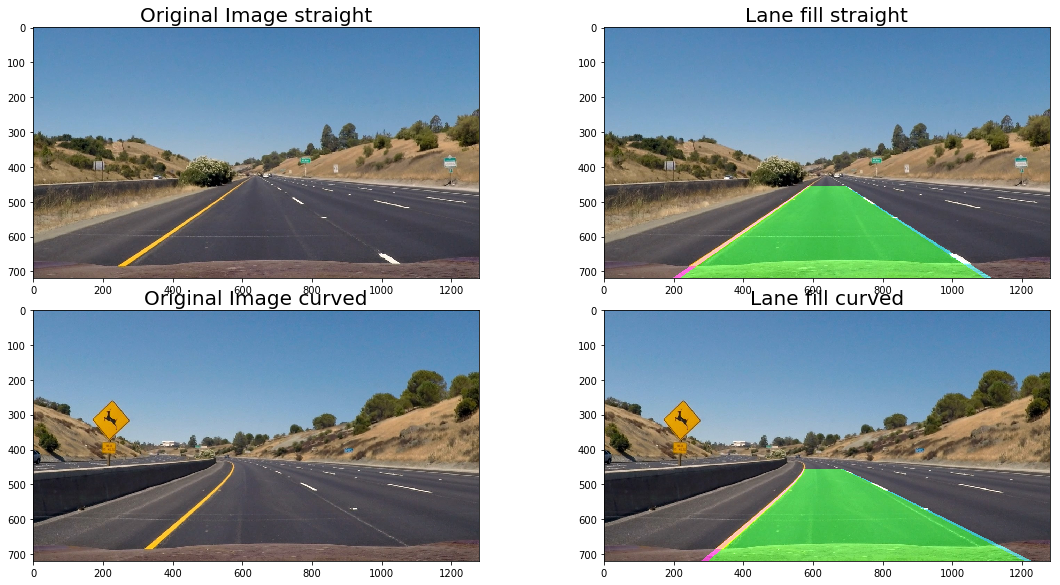

In [29]:
test_img_curved = cv2.imread('./test_images/test2.jpg')
test_img_curved = cv2.cvtColor(test_img_curved, cv2.COLOR_BGR2RGB)
testimg_binary_curved, Minv = binary_img_pipeline(test_img_curved)
left_fit, right_fit, left_lane_inds, right_lane_inds, windows_data, histogram = sliding_window_lane_fit_polynomial(testimg_binary_curved)
testimg_out_curved = lane_area_identify(test_img_curved, testimg_binary_curved, left_fit, right_fit, Minv)

test_img_straight = cv2.imread('./test_images/straight_lines1.jpg')
test_img_straight = cv2.cvtColor(test_img_straight, cv2.COLOR_BGR2RGB)
testimg_binary_straight, Minv = binary_img_pipeline(test_img_straight)
left_fit, right_fit, left_lane_inds, right_lane_inds, windows_data, histogram = sliding_window_lane_fit_polynomial(testimg_binary_straight)
testimg_out_straight = lane_area_identify(test_img_straight, testimg_binary_straight, left_fit, right_fit, Minv)

fig, axs = plt.subplots(2, 2, figsize=(16, 8))
plt.subplots_adjust(hspace = 0, wspace=0)
plt.tight_layout()
axs = axs.ravel()

plt.imsave('./output_images/lane_id_straight.png', testimg_out_straight)
plt.imsave('./output_images/lane_id_curved.png', testimg_out_curved)

    
axs[0].set_title('Original Image straight', fontsize=20)
axs[0].imshow(test_img_straight)
axs[1].set_title('Lane fill straight', fontsize=20)
axs[1].imshow(testimg_out_straight)
                    
axs[2].set_title('Original Image curved', fontsize=20)
axs[2].imshow(test_img_curved)
axs[3].set_title('Lane fill curved', fontsize=20)
axs[3].imshow(testimg_out_curved)

#### Draw lane data on the test image

In [30]:
def project_to_road(original_img, curv_rad, center_dist, position):
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Radius of curvature is {}m'.format(curv_rad)
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = 'Vehicle is {:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img

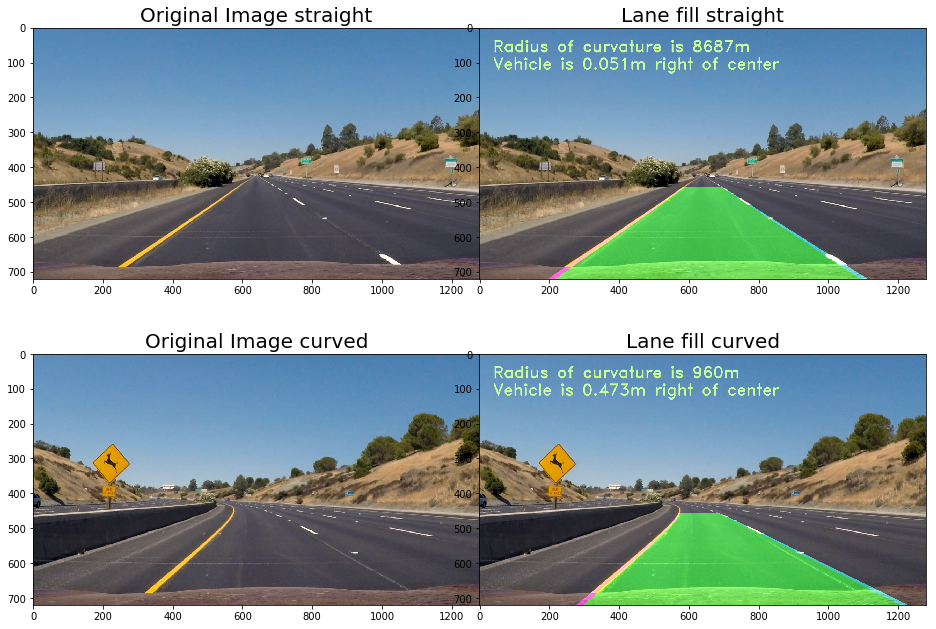

In [31]:
left_fit, right_fit, left_lane_inds, right_lane_inds, windows_data, histogram = sliding_window_lane_fit_polynomial(testimg_binary_straight)
radius, d_center, position = calc_radius_curvature(testimg_binary_straight, left_fit, right_fit, left_lane_inds, right_lane_inds)
testimg_data_straight = project_to_road(testimg_out_straight, radius, d_center, position)

left_fit, right_fit, left_lane_inds, right_lane_inds, windows_data, histogram = sliding_window_lane_fit_polynomial(testimg_binary_curved)
radius, d_center, position = calc_radius_curvature(testimg_binary_curved, left_fit, right_fit, left_lane_inds, right_lane_inds)
testimg_data_curved = project_to_road(testimg_out_curved, radius, d_center, position)
fig, axs = plt.subplots(2, 2, figsize=(16, 12), squeeze=True)
fig.subplots_adjust(hspace = 0, wspace=0)

axs = axs.ravel()

plt.imsave('./output_images/lane_id_straight_stats.png', testimg_out_straight)
plt.imsave('./output_images/lane_id_curved_stats.png', testimg_out_curved)

    
axs[0].set_title('Original Image straight', fontsize=20)
axs[0].imshow(test_img_straight)
axs[1].set_title('Lane fill straight', fontsize=20)
axs[1].imshow(testimg_data_straight)
                    
axs[2].set_title('Original Image curved', fontsize=20)
axs[2].imshow(test_img_curved)
axs[3].set_title('Lane fill curved', fontsize=20)
axs[3].imshow(testimg_data_curved)

### Output Visual display

In [32]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None
    def add_fit(self, fit, inds):
        # add a found fit to the line, up to n
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or \
               self.diffs[1] > 1.0 or \
               self.diffs[2] > 100.) and \
               len(self.current_fit) > 0:
                # bad fit! abort! abort! ... well, unless there are no fits in the current_fit queue, then we'll take it
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # throw out old fits, keep newest n
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # or remove one from the history, if not found
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)


### 8. Pipeline video

In [35]:
def process_image_frame(img):
    new_img = np.copy(img)
    img_bin, _ = binary_img_pipeline(new_img)
    
    # if both left and right lines were detected last frame, use polyfit_using_prev_fit, otherwise use sliding window
    if not l_line.detected or not r_line.detected:
        l_fit, r_fit, l_lane_inds, r_lane_inds, windows_data, histogram = sliding_window_lane_fit_polynomial(img_bin)
    else:
        l_fit, r_fit, l_lane_inds, r_lane_inds = lane_fit_from_prev_frame(img_bin, l_line.best_fit, r_line.best_fit)
        
    
            
    l_line.add_fit(l_fit, l_lane_inds)
    r_line.add_fit(r_fit, r_lane_inds)
    
    # draw the current best fit if it exists
    if l_line.best_fit is not None and r_line.best_fit is not None:
        img_out1 = lane_area_identify(new_img, img_bin, l_line.best_fit, r_line.best_fit, Minv)
        radius, d_center, position = calc_radius_curvature(img_bin, l_line.best_fit, r_line.best_fit, 
                                                               l_lane_inds, r_lane_inds)
        img_out = project_to_road(img_out1, radius, d_center, position)
    else:
        img_out = new_img
    
    return img_out

In [36]:
l_line = Line()
r_line = Line()
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip("project_video.mp4")
processed_video = video_input1.fl_image(process_image_frame)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [05:31<00:00,  3.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 5min 32s
